# Product Image Classifier

## Data Preparation

In [ ]:
# Import the necessary libraries 
import os
import shutil
import random
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
#Re-sizing the images of the dataset
input_dir = "../Product Classifier/Data/original"
output_dir = "../Product Classifier/Data/resized"
target_size = (256, 256)

# List all files in the input directory
files = os.listdir(input_dir)

for file in files:

    # Open the image
    with Image.open(os.path.join(input_dir, file)) as img:
        # Resize the image
        resized_img = img.resize(target_size)

        # Save the resized image to the output directory
        resized_img.save(os.path.join(output_dir, file))

print("Resizing completed.")

Resizing completed.


In [13]:
# Splitting the data into train, validation, and test sets

# Define paths
main_folder = "../Product Classifier/Data/resized"
train_folder = "../Product Classifier/Data/train_data"
val_folder = "../Product Classifier/Data/val_data"
test_folder = "../Product Classifier/Data/test_data"

# Create train, validation, and test folders
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Define the ratio for train, validation, and test sets
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Iterate through each category folder
categories = os.listdir(main_folder)
for category in categories:
    category_path = os.path.join(main_folder, category)
    if os.path.isdir(category_path):
        # Create category folders in train, validation, and test sets
        os.makedirs(os.path.join(train_folder, category), exist_ok=True)
        os.makedirs(os.path.join(val_folder, category), exist_ok=True)
        os.makedirs(os.path.join(test_folder, category), exist_ok=True)
        
        # Get list of image files in the category folder
        images = os.listdir(category_path)
        
        # Shuffle the images randomly
        random.shuffle(images)
        
        # Calculate the number of images for each set
        num_train = int(len(images) * train_ratio)
        num_val = int(len(images) * val_ratio)
        num_test = len(images) - num_train - num_val
        
        # Split images into train, validation, and test sets
        train_images = images[:num_train]
        val_images = images[num_train:num_train + num_val]
        test_images = images[num_train + num_val:]
        
        # Move images to respective folders
        for image in train_images:
            src = os.path.join(category_path, image)
            dst = os.path.join(train_folder, category, image)
            shutil.copyfile(src, dst)
        
        for image in val_images:
            src = os.path.join(category_path, image)
            dst = os.path.join(val_folder, category, image)
            shutil.copyfile(src, dst)
        
        for image in test_images:
            src = os.path.join(category_path, image)
            dst = os.path.join(test_folder, category, image)
            shutil.copyfile(src, dst)

print("Data split and prepared successfully!")

Data split and prepared successfully!


## Data preprocessing and Model building

In [18]:
# Data augmantation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generator
train_generator = train_datagen.flow_from_directory(train_folder, target_size=(256, 256), batch_size=32, class_mode='sparse')
val_generator = val_datagen.flow_from_directory(val_folder, target_size=(256, 256), batch_size=32, class_mode='sparse')
test_generator = test_datagen.flow_from_directory(test_folder, target_size=(256, 256), batch_size=32, class_mode='sparse')

# Model Building
# Load the pre-trained ResNet50 model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers (Fine-Tuning)
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(8, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=[SparseCategoricalAccuracy()])

# Train the model
model.fit(train_generator, epochs=10, validation_data=val_generator)

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Save the trained model
model.save("../Product Classifier/resnet50_custom_model.h5")

print("Model saved successfully!")

Found 483 images belonging to 8 classes.
Found 101 images belonging to 8 classes.
Found 113 images belonging to 8 classes.
Epoch 1/10
16/16 [==============================] - 137s 7s/step - loss: 24.7302 - sparse_categorical_accuracy: 0.1905 - val_loss: 10.0223 - val_sparse_categorical_accuracy: 0.1881
Epoch 2/10
16/16 [==============================] - 106s 7s/step - loss: 10.5151 - sparse_categorical_accuracy: 0.3851 - val_loss: 5.9974 - val_sparse_categorical_accuracy: 0.3564
Epoch 3/10
16/16 [==============================] - 112s 7s/step - loss: 3.2939 - sparse_categorical_accuracy: 0.4493 - val_loss: 3.6812 - val_sparse_categorical_accuracy: 0.4158
Epoch 4/10
16/16 [==============================] - 112s 7s/step - loss: 2.1105 - sparse_categorical_accuracy: 0.5342 - val_loss: 1.9915 - val_sparse_categorical_accuracy: 0.5842
Epoch 5/10
16/16 [==============================] - 111s 7s/step - loss: 2.4542 - sparse_categorical_accuracy: 0.5031 - val_loss: 3.0520 - val_sparse_categori

## Testing the Model

1/1 [==============================] - 5s 5s/step


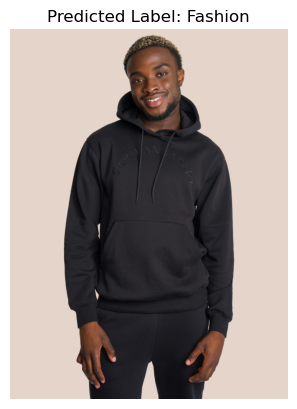

In [30]:
# Load the saved model
model = load_model("../Product Classifier/resnet50_custom_model.h5")

# Define a function to preprocess the input image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values
    return img_array

# Define the path to the test image
test_img_path = "../Product Classifier/test_image.jpg"

# Preprocess the test image
test_img = preprocess_image(test_img_path)

# Make predictions
predictions = model.predict(test_img)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Define a dictionary mapping class indices to class labels
class_labels = {0: 'Accessories', 1: 'Artefacts', 2: 'Beauty', 3: 'Fashion', 4: 'Games', 5: 'Home', 6: 'Nutrition', 7: 'Stationary'}

plt.imshow(image.load_img(test_img_path))
plt.title(f"Predicted Label: {class_labels[predicted_class]}")
plt.axis('off')
plt.show()

1/1 [==============================] - 1s 983ms/step


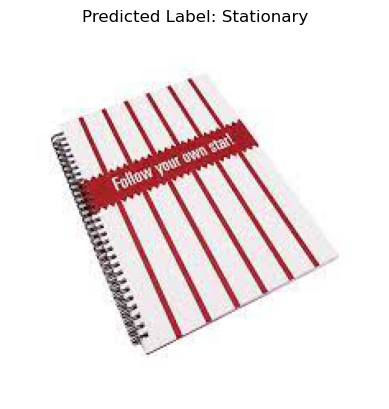

In [34]:
test_img_path = "../Product Classifier/test_image-2.jpg"
test_img = preprocess_image(test_img_path)
predictions = model.predict(test_img)
predicted_class = np.argmax(predictions)

plt.imshow(image.load_img(test_img_path))
plt.title(f"Predicted Label: {class_labels[predicted_class]}")
plt.axis('off')
plt.show()

1/1 [==============================] - 1s 793ms/step


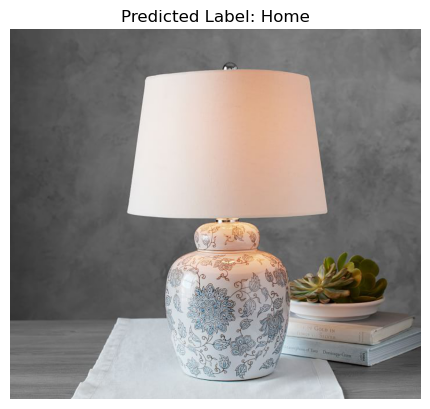

In [37]:
test_img_path = "../Product Classifier/test_image-3.jpg"
test_img = preprocess_image(test_img_path)
predictions = model.predict(test_img)
predicted_class = np.argmax(predictions)

plt.imshow(image.load_img(test_img_path))
plt.title(f"Predicted Label: {class_labels[predicted_class]}")
plt.axis('off')
plt.show()